In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond

In [2]:
n = 1000
stencil_size = 31

# Generate Nodes

In [3]:
indices = np.arange(0, n, dtype=float) + 0.5

phi = np.arccos(1 - 2*indices/n)
theta = np.pi * (1 + 5**0.5) * indices

xs, ys, zs = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
nodes = [(x,y,z) for x,y,z in zip(xs,ys,zs)]

projectors = [np.eye(3) - np.outer(node, node) for node in nodes]

In [4]:
projectors[0]

array([[ 9.99737500e-01,  6.75152549e-04, -1.61856439e-02],
       [ 6.75152549e-04,  9.98263500e-01,  4.16296641e-02],
       [-1.61856439e-02,  4.16296641e-02,  1.99900000e-03]])

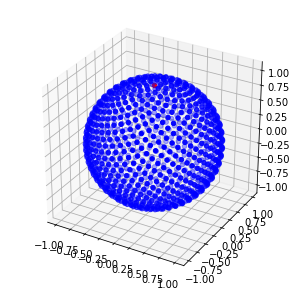

In [5]:
# Plot nodes
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[1:], ys[1:], zs[1:], c='b')
ax.scatter(xs[0], ys[0], zs[0], c='r')

In [6]:
tree = cKDTree(np.array(nodes))
stencils = [tree.query(node, stencil_size)[1] for node in nodes]

# Functions

In [7]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def rbf(node1, node2):
    r = dist(node1, node2)
    return r**7
def d_phi_dr_div_r(r):
    return 7*r**5

def grad_rbf(node, node_center):
    r = dist(node, node_center)
    return d_phi_dr_div_r(r) * (np.array(node) - np.array(node_center))
    

In [8]:
print(grad_rbf(nodes[0], nodes[1]))
print(projectors[1]@grad_rbf(nodes[0], nodes[1]))

[ 1.17656970e-05 -1.04333500e-05  2.74853783e-07]
[ 1.17032275e-05 -1.04025277e-05  1.17213042e-06]


# Calculate Weights

In [9]:
weights = np.zeros((n, stencil_size))
row_index = [r for r in range(n) for c in range(stencil_size)]
col_index = np.zeros((n, stencil_size))

for i, stencil in enumerate(stencils):
    #if i==1: break
    col_index[i] = stencil
    nn = [nodes[i] for i in stencil]
    nn_proj = [projectors[i] for i in stencil]
    center_x, center_y, center_z = nn[0]
    
    A = np.array([[rbf(node, node_center) for node in nn] for node_center in nn])
    P = np.array([[1, x-center_x, y-center_y, z-center_z] for x,y,z in nn])
    AP = np.block([[A,P],[P.T, np.zeros((4,4))]])
    
    rhsAs = np.array([ [ nn_proj[j]@grad_rbf(node, node_center) for j, node in enumerate(nn) ] for node_center in nn] )
    
    rhsA = rhsAs[:,:,0] # only the x coordinates
    rhs = np.block([[rhsA],
                    [np.zeros(stencil_size)],
                    [1-node[0]**2 for node in nn],
                    [-node[0]*node[1] for node in nn],
                    [-node[0]*node[2] for node in nn] ])
    weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
    weights[i] = (weights_grad@weights_grad)[0]
    
    rhsA = rhsAs[:,:,1] # only the y coordinates
    rhs = np.block([[rhsA],
                    [np.zeros(stencil_size)],
                    [-node[0]*node[1] for node in nn],
                    [1-node[1]**2 for node in nn],
                    [-node[1]*node[2] for node in nn] ])
    weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
    weights[i] += (weights_grad@weights_grad)[0]
    
    rhsA = rhsAs[:,:,2] # only the z coordinates
    rhs = np.block([[rhsA],
                    [np.zeros(stencil_size)],
                    [-node[0]*node[2] for node in nn],
                    [-node[1]*node[2] for node in nn],
                    [1-node[2]**2 for node in nn] ])
    weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
    weights[i] += (weights_grad@weights_grad)[0]
    
C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

In [10]:
cond(C.todense())

3.4925602543735652e+16

In [11]:
print(projectors[0])
print(projectors[0]@[[0],[1],[0]])

[[ 9.99737500e-01  6.75152549e-04 -1.61856439e-02]
 [ 6.75152549e-04  9.98263500e-01  4.16296641e-02]
 [-1.61856439e-02  4.16296641e-02  1.99900000e-03]]
[[6.75152549e-04]
 [9.98263500e-01]
 [4.16296641e-02]]


In [12]:
(projectors[0]@grad_rbf(nodes[0], nodes[1]))

array([ 1.17511158e-05, -1.03958468e-05, -6.24222807e-07])

In [13]:
nn[0]

(0.007002049456068807, 0.04415847940559732, -0.9990000000000001)

In [14]:
nodes[0]

(0.016201845770180603, -0.04167133539544039, 0.999)

In [15]:
rhsAs[:,:,0]

array([[ 0.00000000e+00, -5.50036145e-06,  8.57359020e-06,
         1.17613913e-05, -9.23267534e-06, -1.77167547e-05,
        -2.05847892e-04, -5.86164858e-06,  1.28466740e-04,
         3.24190144e-04,  2.72816999e-04, -4.98007447e-04,
        -5.43270586e-04, -5.47294607e-04,  1.20101721e-03,
        -2.66398702e-06,  1.79150021e-03,  6.17407472e-04,
        -2.10046842e-03, -3.54544795e-03,  2.20387680e-03,
        -3.62235672e-03,  4.78719029e-03, -2.04597404e-03,
        -1.10616012e-03,  3.78064765e-03,  1.98360520e-03,
         8.47416289e-03, -6.12363560e-03, -1.13772398e-02,
         1.04953673e-02],
       [ 5.52258190e-06,  0.00000000e+00,  4.34797516e-04,
         2.42167440e-04,  6.81070549e-06,  4.27202820e-06,
        -1.95196919e-05,  4.18988384e-04,  4.79021589e-04,
         3.19651613e-03,  3.06110651e-03, -1.28977369e-05,
        -2.12737845e-05, -1.19058797e-04,  5.71790998e-03,
         3.58597991e-04,  1.19833266e-02,  4.62445096e-03,
        -6.24348501e-04, -4.61

# Extra Condition

In [16]:
Clam = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                    np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')

In [17]:
print(cond(Clam.todense()))

242.601724878604


# Solve

In [18]:
# l=1
def foo1(node):
    return node[0]*2
def exact1(node):
    return node[0]


# l=3
def foo2(node):
    return (node[0]**2 - node[1]**2) * 6
def exact2(node):
    return (node[0]**2 - node[1]**2)

def foo3(node):
    return (node[0]**2 - node[1]**2) * node[2] * 12
def exact3(node):
    return (node[0]**2 - node[1]**2) * node[2]


foo, exact = foo1, exact1

In [19]:
rhs = [-foo(node) for node in nodes] + [0]
#u = lsqr(Clam, rhs)[0]
u = spsolve(Clam, rhs)
u = u[:-1]

In [20]:
################################################################
#
# PHS
#
################################################################

u_true = np.array([exact(node) for node in nodes])
print(np.max( np.abs( (u - u_true)/u_true) ) )
print(np.min(u))
print(np.max(u))

0.014182518885898918
-0.9997973933708649
0.9988911585665358


# Plot Solution

Text(0.5,0,'y')

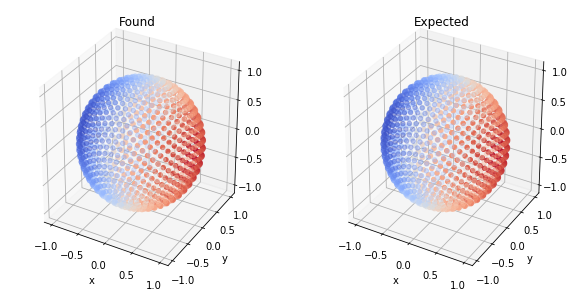

In [21]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(xs, ys, zs, c=u, cmap='coolwarm')
ax.set_title('Found')
plt.xlabel('x')
plt.ylabel('y')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(xs, ys, zs, c=[exact(node) for node in nodes], cmap='coolwarm')
ax.set_title('Expected')
plt.xlabel('x')
plt.ylabel('y')